In [108]:
import sys
import pandas as pd
import datetime
import os.path
from os import path
import requests
import numpy as np
import time
import pytz
# from sklearn.impute import KNNImputer
import json
from sklearn.metrics import mean_absolute_error
from sklearn.cluster import KMeans
import calendar
import os
from dateutil.relativedelta import relativedelta
from dateutil.tz import gettz
import timeit
# from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import scipy as sp
from scipy import signal
% matplotlib inline
address = "https://m3.meazon.com/"

In [131]:
def download_nrg(start_date, end_date, devid):
    global address

    r = requests.post(address + "api/auth/login",
                      json={'username': 'meazon@thingsboard.org', 'password': 'meazon'}).json()

    # acc_token is the token to be used in the next request
    acc_token = 'Bearer' + ' ' + r['token']

    start_time = str(start_date)
    end_time = str(end_date)

    r2 = requests.get(
        url=address + "api/plugins/telemetry/DEVICE/" + devid + "/values/timeseries?keys=pwrA,pwrB,pwrC,rpwrA,rpwrB,rpwrC&startTs=" + start_time + "&endTs=" + end_time + "&agg=NONE&limit=1000000",
        headers={'Content-Type': 'application/json', 'Accept': '*/*', 'X-Authorization': acc_token}).json()

    if r2:
        df = pd.DataFrame([])

        for desc in r2.keys():
            df1 = pd.DataFrame(r2[desc])
            df1.set_index('ts', inplace=True)
            df1.columns = [str(desc)]
            df = pd.concat([df,df1], axis=1,sort = True)

        

        df.reset_index(drop=False, inplace=True)
        df['ts'] = pd.to_datetime(df['ts'], unit='ms')

        df = df.sort_values(by=['ts'])
        df.reset_index(drop=True, inplace=True)
        df = df.rename(columns = {"ts": "Timestamp"})
        
    else:
        df = pd.DataFrame([])
        print('Empty json!')
    

    return [df,acc_token]



def create_nrg_table(df,interval):
    
    df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='%Y/%m/%d %H:%M:%S.%f')
    df = df.sort_values(by="Timestamp")

    df['Timestamp'] = df['Timestamp'].astype('datetime64[s]')
    df = df.set_index('Timestamp', drop=True)
    
    
    for col in df.columns:
        df[col] = df[col].astype('float64')

    
    
    #df.index = df.index.map(lambda x: x.replace(second=0))
    ####################
    
    ##########set timezone
#     df['ts'] = df.index
#     df['ts'] = df['ts'].dt.tz_localize('utc').dt.tz_convert('Europe/Athens')
#     df.reset_index(drop=True, inplace=True)
#     df.set_index('ts',inplace = True, drop = True)

#     df = df.resample(interval+'T',label = 'right',closed = 'right').max()
#     df.reset_index(inplace = True, drop = False)
#     df.set_index('ts',inplace = True, drop = False)

    return df

In [132]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

def gof(x,y,step):
    lgof = np.sum((y-x)**2/x)
    if lgof> 6:#chi[step-2]:
        lgof=1
    else:
        lgof= 0
    return lgof

chi = [6.63,9.21,11.3,13.3,15.1,16.8,18.5,20.1,21.7,23.2,24.7,26.2,27.7,29.1,30.6,32,33.4,34.8,36.2,37.6,38.9,40.3,41.6,43,44.3,45.6,47,48.3,49.6]

In [171]:
# devid = 'af77d5e0-fc8f-11e9-ba33-b705eb64bbb5'
devid = '0c256d00-6187-11ea-8762-6bf954fc5af1' # stelios
# devid = 'be441c40-5889-11ea-8762-6bf954fc5af1' # aimilia
# start_time = '1585540800000'
# end_time = '1585654657000'
start_time = '1585903780000'
end_time = '1585905833000'



interval = '1'

[dfcnrg,acc_token] = download_nrg(start_time, end_time, devid)
df = create_nrg_table(dfcnrg,interval)
df['totalpwr'] = np.sqrt((df['pwrA'])**2+(df['rpwrA'])**2)
# df['totalpwr'] = df['rpwrA']


df['active'] = df['pwrA']
df['reactive'] = df['rpwrA']
# df =df[['totalpwr','active']]
dfcomp = df[['totalpwr','active','reactive']]
df =df[['totalpwr']]

df = df.dropna()
dfcomp = dfcomp.dropna()
dfcomp['totalpwr'] = sp.signal.medfilt(dfcomp['totalpwr'])
df['totalpwr'] = sp.signal.medfilt(df['totalpwr'])
df.head()


,totalpwr
Timestamp,
2020-04-03 08:49:41,2.466405
2020-04-03 08:49:42,2.466405
2020-04-03 08:49:43,2.459200
2020-04-03 08:49:44,2.459200
2020-04-03 08:49:45,2.472819


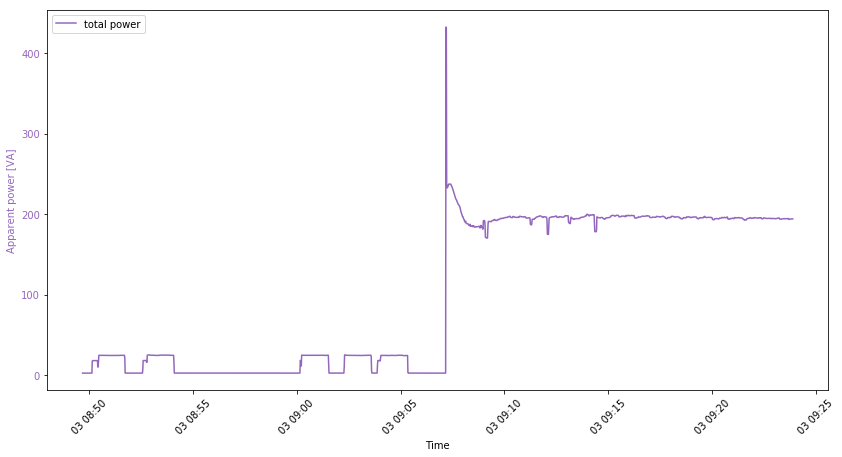

In [150]:
# plot raw data
i=0
fig, ax1 = plt.subplots(figsize=(14, 7.0))
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)

color = 'tab:purple'
ax1.set_xlabel('Time')
ax1.set_ylabel('Apparent power [VA]', color=color)
ax1.plot(df.index, df['totalpwr'], color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(['total power'], loc=2)


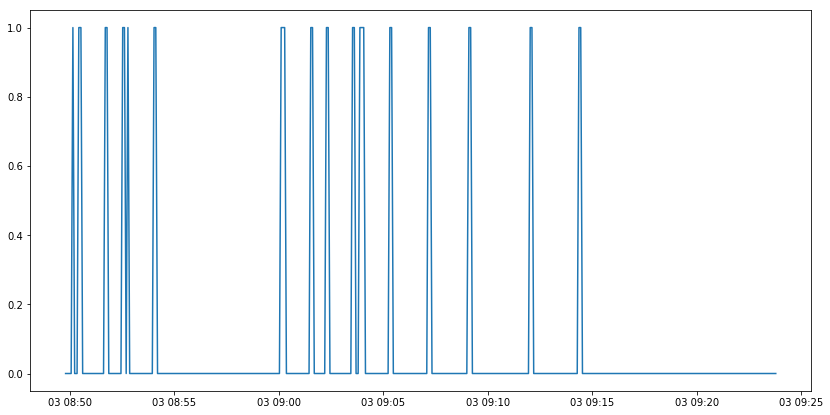

In [209]:
# Define window size as step, apply gof function over rows to detect events

step = 5
supervised = series_to_supervised(df, step, step)
supervised = supervised.iloc[1::step, :]
# supervised['lgof']=0

# for i in range(0,supervised.shape[0]):
#     supervised['lgof'].iloc[i] = gof(supervised[supervised.columns[:step]].iloc[i].values,supervised[supervised.columns[step:-1]].iloc[i].values,step)
gof_row = lambda row: gof(row[:step].values, row[step:].values,step)
supervised['lgof'] = supervised.apply(gof_row,axis=1) #lambda row : gof(row[['var1(t-3)','var1(t-2)','var1(t-1)']].values,row[['var1(t)','var1(t+1)','var1(t+2)']].values ), axis = 1) 

fig = plt.figure(figsize=(14, 7.0))
plt.plot(supervised.index,supervised.lgof)

In [210]:
# Average df's rows every [step] rows and concatenate active and apparent power to supervised

dfn = dfcomp.iloc[step+1:].copy()
dfn['ts'] = dfn.index
dfn.reset_index(inplace=True,drop=True)
dfn = dfn.groupby(np.arange(len(dfn))//step).mean()
dfn = dfn.iloc[:-1]
supervised['totalpwr'] = dfn['totalpwr'].values
supervised['active'] = dfn['active'].values
supervised['reactive'] = dfn['reactive'].values


In [211]:
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
# supervised

In [212]:
dfn = supervised.copy()
dfn = dfn[['totalpwr','active','reactive','lgof']]
dfn.head()

,totalpwr,active,reactive,lgof
Timestamp,,,,
2020-04-03 08:49:48,2.481966,1.9852,1.4916,0
2020-04-03 08:49:54,2.478090,1.9792,1.4898,0
2020-04-03 08:49:59,2.482186,1.9800,1.4970,0
2020-04-03 08:50:04,2.485541,1.9808,1.4990,0
2020-04-03 08:50:09,17.922333,17.8716,1.3136,1


In [213]:
# supper = np.ma.masked_where(dfn['lgof']==1, dfn['totalpwr'])
# slower = np.ma.masked_where(dfn['lgof'] ==0, dfn['totalpwr'])
# fig, ax = plt.subplots(figsize=(14, 7.0))
# plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
# ax.plot(dfn.index, supper,'-',dfn.index,slower,'-*')
# ax.legend(['No event','Event'])

Text(0.5,1,'Event detection')

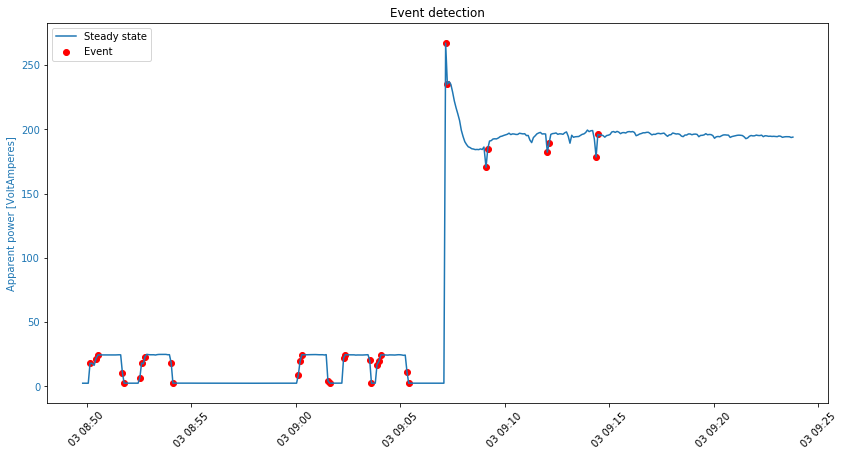

In [214]:

import matplotlib.colors as colors

fig, ax1 = plt.subplots(figsize=(14, 7.0))
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
color = 'tab:blue'
ax1.plot(dfn.index, dfn['totalpwr'], '-')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylabel('Apparent power [VoltAmperes]', color=color)
# Add below threshold markers
below_threshold = dfn['lgof']>0
ax1.scatter(dfn.index[below_threshold], dfn['totalpwr'][below_threshold], color='red') 
ax1.legend(['Steady state','Event'],loc=2)


# ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

# color = 'tab:orange'


# ax2.set_ylabel('Active power [Watts]', color=color)  # we already handled the x-label with ax1
# ax2.plot(dfn.index, dfn['active'], '-',color=color)
# ax2.tick_params(axis='y', labelcolor=color)
# ax2.legend(['Active power'], loc=1)
plt.title('Event detection')

In [261]:
dfpost = dfn[dfn['lgof']>0].copy()
dfpost.drop('lgof', axis=1, inplace=True)
dfpost.head()

,totalpwr,active,reactive
Timestamp,,,
2020-04-03 08:50:09,17.922333,17.8716,1.3136
2020-04-03 08:50:26,21.679852,12.6284,17.7006
2020-04-03 08:50:32,24.511606,14.0390,20.0872
2020-04-03 08:51:42,10.596023,6.4180,8.3556
2020-04-03 08:51:47,2.501039,1.9938,1.5140


In [262]:
dfpost['prev']=dfpost['reactive'].shift()
dfpost['prev'].iloc[0]=0
dfpost.head()

,totalpwr,active,reactive,prev
Timestamp,,,,
2020-04-03 08:50:09,17.922333,17.8716,1.3136,0.0000
2020-04-03 08:50:26,21.679852,12.6284,17.7006,1.3136
2020-04-03 08:50:32,24.511606,14.0390,20.0872,17.7006
2020-04-03 08:51:42,10.596023,6.4180,8.3556,20.0872
2020-04-03 08:51:47,2.501039,1.9938,1.5140,8.3556


In [267]:
km = KMeans(n_clusters=4, init='k-means++', max_iter=100, n_init=50)

print("Clustering sparse data with %s" % km)

dfpost['cluster'] = km.fit_predict(dfpost[['totalpwr','reactive']].values)

Clustering sparse data with KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
    n_clusters=4, n_init=50, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)


In [268]:
clustered = pd.concat([dfn,dfpost['cluster']],axis = 1)


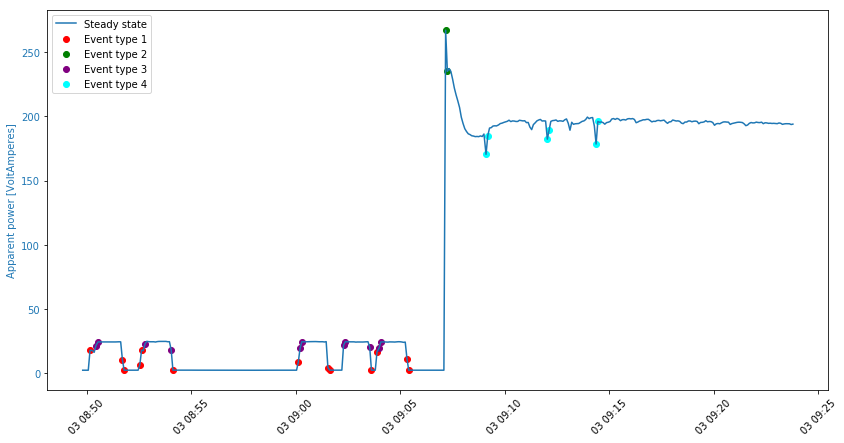

In [272]:
fig, ax1 = plt.subplots(figsize=(14, 7.0))
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
color = 'tab:blue'
ax1.plot(clustered.index, clustered['totalpwr'], '-')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylabel('Apparent power [VoltAmperes]', color=color)

# Add below threshold markers
cl0 = clustered['cluster']==0
cl1 = clustered['cluster']==1.0
cl2 = clustered['cluster']==2.0
cl3 = clustered['cluster']==3.0
# cl4 = clustered['cluster']==4.0

ax1.scatter(clustered.index[cl0], clustered['totalpwr'][cl0], color='red') 
ax1.scatter(clustered.index[cl1], clustered['totalpwr'][cl1], color='green') 
ax1.scatter(clustered.index[cl2], clustered['totalpwr'][cl2], color='purple') 
ax1.scatter(clustered.index[cl3], clustered['totalpwr'][cl3], color='cyan') 
# ax1.scatter(clustered.index[cl4], clustered['totalpwr'][cl4], color='orange') 


ax1.legend(['Steady state','Event type 1','Event type 2','Event type 3','Event type 4'],loc=2)

In [ ]:
#############################################################################################

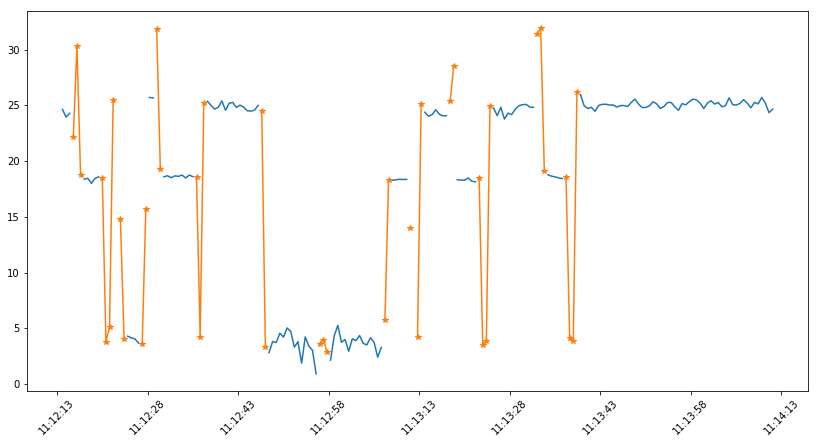

In [169]:
supper = np.ma.masked_where(df['lgof']==1, df['totalpwr'])
slower = np.ma.masked_where(df['lgof'] ==0, df['totalpwr'])
fig, ax = plt.subplots(figsize=(14, 7.0))
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
ax.plot(df.index, supper,'-',df.index,slower,'-*')

In [29]:
df = pd.concat([df,supervised['lgof']],axis = 1)
df = df.iloc[3:]
# df.dropna(inplace = True)
df.head()

,totalpwr,lgof
Timestamp,,
2020-04-02 11:12:13.341,24.326642,NaN
2020-04-02 11:12:13.361,24.326642,0.0
2020-04-02 11:12:13.381,24.386135,NaN
2020-04-02 11:12:13.401,24.393076,NaN
2020-04-02 11:12:13.421,24.393076,0.0


In [30]:
for i in range(1,df.shape[0],3):
    if df['lgof'].iloc[i]>0:
        df['lgof'].iloc[i:i+3]=0
        
        difn = df['totalpwr'].iloc[i-1] - df['totalpwr'].iloc[i]
        dif1 = df['totalpwr'].iloc[i] - df['totalpwr'].iloc[i+1]
        dif2 = df['totalpwr'].iloc[i+1] - df['totalpwr'].iloc[i+2]
        
        if np.abs(np.abs(dif1-dif2)>10):

            maxind = np.argmax([np.abs(difn),np.abs(dif1),np.abs(dif2)])
            mx = [difn,dif1,dif2][maxind]
            
            if maxind>0:
                df['lgof'].iloc[i+maxind]=1
#                 if mx<0:
#                     df['lgof'].iloc[i+maxind+1]=1
#                 else:
#                     df['lgof'].iloc[i+maxind]=1
            else:
                df['lgof'].iloc[i]=1
        else:
            df['lgof'].iloc[i]=1
    else:
        df['lgof'].iloc[i:i+3]=0
        

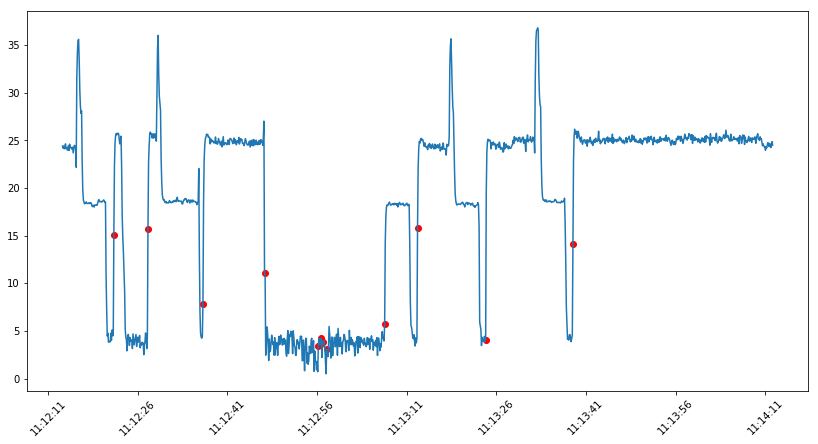

In [65]:

import matplotlib.colors as colors

fig, ax = plt.subplots(figsize=(14, 7.0))
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
ax.plot(df.index, df['totalpwr'], '-')
# Add below threshold markers
below_threshold = df['lgof']>0
plt.scatter(df.index[below_threshold], df['totalpwr'][below_threshold], color='red') 

